# Generation of Kerr sideband


Kerr sidebands can significantly enhance sensor resolution through all-optical signal processing. By combining a tunable laser source and a pump laser with a Fiber Bragg Grating (FBG) in a nonlinear fiber, frequency sidebands are generated, with each sideband’s power dependent on input intensities. Filtering specific sidebands narrows the FBG-reflected signal, improving wavelength shift detection. This technique enhances FBG-based temperature sensors and can be applied to other optical systems for increased resolution.

In this notebook, we use Tidy3D to perform a simulation of the generation of Kerr sideband in a waveguide. This example is based on the paper from `Ole Krarup, Chams Baker, Liang Chen, and Xiaoyi Bao " Nonlinear resolution enhancement of an FBG based temperature sensor using the Kerr effect." Optics Express Vol. 28, Issue 26, pp. 39181-39188 (2020)` [Doi: https://doi.org/10.1364/OE.411179](https://doi.org/10.1364/OE.411179)

This example was kindly created by Dr. Chenchen Wang.

<img src="img/kerrSideband.png" width="600" alt="Schematic">

For more examples, please refer to our [learning center](https://www.flexcompute.com/tidy3d/examples/), where you can find tutorials such as [Bistability in photonic crystal microcavities](https://www.flexcompute.com/tidy3d/examples/notebooks/BistablePCCavity/).

FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.


### Theoretical base



In this section, we will introduce the theoretical framework of generating sidebands in a Kerr medium, as developed in the [reference paper](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-26-39181&id=444709).

To generate Kerr sidebands, we inject laser light with two distinct angular frequencies into a Kerr medium. The two frequencies are a signal frequency $\omega_s$ and a pump frequency $\omega_p$, where $\omega_s < \omega_p$. The Kerr medium is a waveguide made of a $\chi^{(3)}$ material. The total electric field amplitude at the input of the fiber is given by:

$$
A_{\text{in}} = \left[\sqrt{P_s} \exp(-0.5i\omega_s t) + \sqrt{P_p} \exp(0.5i\omega_p t)\right]
$$

where $P_s$ and $P_p$ are the powers of the signal and pump fields, respectively. The angular frequency difference between the signal and pump is defined as $\omega_d = \omega_p - \omega_s$. The input field’s power is:

$$
|A_{\text{in}}|^2 = P_s + P_p + 2 \sqrt{P_s P_p} \cos(\omega_d t)
$$

Neglecting the effects of dispersion, loss, and polarization, the evolution of this field is governed by the **Non-linear Schrödinger Equation (NLSE)**:

$$
\frac{dA}{dz} = i\gamma |A|^2 A
$$

where $A$ is the complex amplitude of the electric field, $z$ is the propagation distance, and $\gamma$ is the nonlinear coefficient of the medium. The term $i\gamma |A|^2$ represents the third order nonlinear interaction of the electric field with the medium, where the field strength $|A|^2$ is proportional to the intensity.

 Solving this differential equation, the field at the output of the waveguide is given by:

$$
A_{\text{out}} = A_{\text{in}} \exp\left[i\gamma L (P_s + P_p)\right] \exp\left[i \gamma L \cdot 2 \sqrt{P_s P_p} \cos(\omega_d t)\right]
$$

Here, $L$ is the length of the waveguide. The exponential term $\exp[i\gamma L (P_s + P_p)]$ can be neglected as it does not affect the overall output power.

The term involving $\cos(\omega_d t)$ can be expanded using the **Jacobi-Anger expansion**:

$$
\exp[i M \cos(\Omega t)] = \sum_{n=-\infty}^{\infty} i^n J_n(M) \exp(in\Omega t)
$$

where $J_n(M)$ is the Bessel function of the first kind of order $n$. Applying this expansion to the second exponential term:

$$
\exp\left[i \gamma L \cdot 2 \sqrt{P_s P_p} \cos(\omega_d t)\right]
$$

The output field becomes a sum of frequency sidebands, spaced by $\omega_d$:

$$
A_{\text{out}} = \sum_{n=-\infty}^{\infty} i^n \exp\left(i \omega_d (n + \frac{1}{2}) t \right) \left[i J_{n+1}\left( 2 \gamma L \sqrt{P_s P_p} \right) \sqrt{P_s} + J_n \left( 2 \gamma L \sqrt{P_s P_p} \right) \sqrt{P_p}\right]
$$

This result indicates that the output field is a superposition of several frequency components, with the sidebands separated by $\omega_d$.

The power of the $n$-th sideband is given by:

$$
|A_n|^2 = J_{|n+1|}^2 \left( 2 \gamma L \sqrt{P_s P_p} \right) P_s + J_{|n|}^2 \left( 2 \gamma L \sqrt{P_s P_p} \right) P_p
$$

Introducing the normalization $x = \gamma L P_p$, $y = \gamma L P_s$, we have:

$$
z_n = x J_{n+1}^2 \left( 2 \sqrt{x y} \right) + y J_n^2 \left( 2 \sqrt{x y} \right)
$$

Here we agree that $z_0$ refers to $y$, $z_{-1}$ refers to $x$ and the Indexes grow from low frequency to high frequency. 

Under the condition $0 < M < \sqrt{1 + n}$, the power in the $n$-th order sideband can be approximated as:

$$
z_n \approx x^{|n+1| + 1} y^{|n+1|} \frac{1}{\left[ (|n+1|)! \right]^2} + x^{|n|} y^{|n|+1}\frac{1}{\left[ (|n|)! \right]^2}
$$

This equation shows that the normalized output power is proportional to the normalized input power, raised to an integer exponent.


As an example, filtering out the $n = 1$ sideband yields:

$$
z_{1} \approx x^3y^2\frac{1}{4} + xy^2
$$


Similarly for $n = -2$ sideband:

$$
z_{-2} \approx y^3x^2\frac{1}{4} + yx^2
$$

This implies an symmetry between $z_{1}$,$z_{-2}$ and $x$,$y$ which can be verified later in simulation.



### Initial setup


First we start defining the parameters for the simulation:

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

# define geometry
wg_width = 0.25
wg_length = 2.5
wg_spacing = 0.5
buffer = 1.0

# compute quantities based on geometry parameters
x_span = 2 * wg_spacing + 2 * wg_length + 2 * buffer
y_span = wg_width  + 2 * buffer
wg_insert_x = wg_length + wg_spacing

Define frequency:

In [2]:
# wavelength range of interest
lambda_beg = 0.5
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

freqd = 1e13

freqp = freq0 + 0.5 * freqd 
freqs = freq0 - 0.5 * freqd

# frequency for the first sideband
freq1 = freqs + (freqp-freqs)

min_steps_per_wvl = 30
run_time = 5e-12

Define materials:

In [3]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

# define the nonlinear parameters
n_kerr_2 = 2e-8
kerr_chi3 = 4 * (n_solid**2) * td.constants.EPSILON_0 * td.constants.C_0 * n_kerr_2 / 3
amp=400
chi3_model = td.NonlinearSpec(models=[td.NonlinearSusceptibility(chi3=kerr_chi3)],num_iters=10)
kerr_solid = td.Medium(permittivity=n_solid**2,
                      nonlinear_spec=chi3_model
                       )

Define structures:

In [4]:
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, wg_width, 0.22],
    ),
    medium=kerr_solid,
    name="waveguide",
)

Compute and visualize the waveguide modes.

13:03:39 -03 Mode solver created with                                           
             task_id='fdve-cb8a927e-6656-4a5e-b18a-e4289a8b4b34',               
             solver_id='mo-26c86f10-0c28-44f8-8206-7cd5134a1587'.

Output()

Output()

13:03:43 -03 Mode solver status: success

Output()

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
5.496195e+14 0             0.545455  1.108526    0.0          0.984406   
             1             0.545455  1.094335    0.0          0.017490   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
5.496195e+14 0                 0.858946        0.895359   0.201495  
             1                 0.846849        0.898209   0.205158

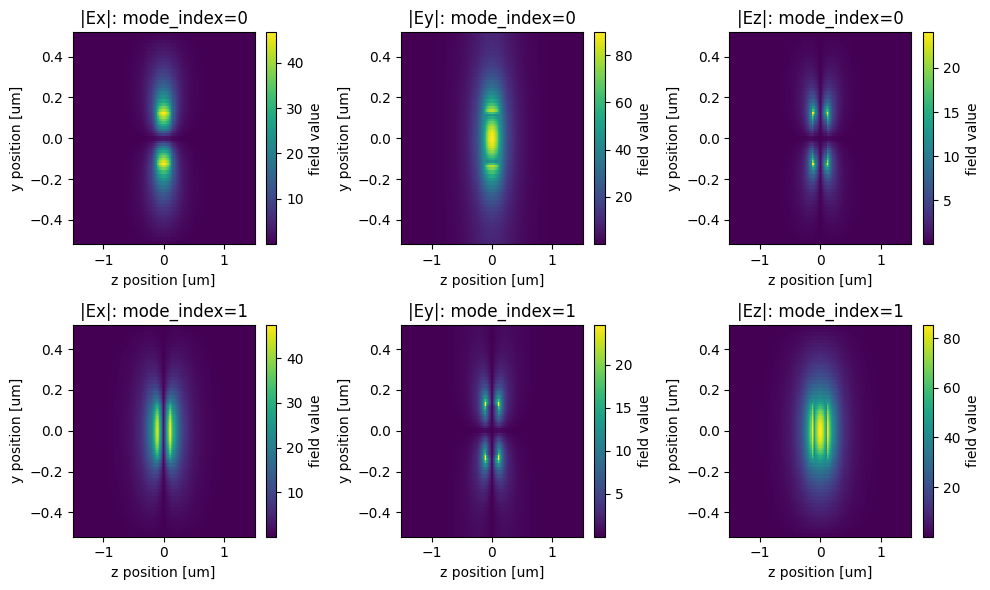

In [5]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_ms

mode_plane = td.Box(
    center=[-wg_insert_x, 0, 0],
    size=[0,1, td.inf],
)

sim_modesolver = td.Simulation(
    center=[0, 0, 0],
    size=[x_span, y_span, 3],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    structures=[waveguide],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
    medium=background,
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(
    simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0]
)
mode_data = run_ms(mode_solver)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, tight_layout=True, figsize=(10, 6)
)
mode_data.Ex.sel(mode_index=0, f=freq0).abs.plot(ax=ax1)
mode_data.Ey.sel(mode_index=0, f=freq0).abs.plot(ax=ax2)
mode_data.Ez.sel(mode_index=0, f=freq0).abs.plot(ax=ax3)
mode_data.Ex.sel(mode_index=1, f=freq0).abs.plot(ax=ax4)
mode_data.Ey.sel(mode_index=1, f=freq0).abs.plot(ax=ax5)
mode_data.Ez.sel(mode_index=1, f=freq0).abs.plot(ax=ax6)
ax1.set_title("|Ex|: mode_index=0")
ax2.set_title("|Ey|: mode_index=0")
ax3.set_title("|Ez|: mode_index=0")
ax4.set_title("|Ex|: mode_index=1")
ax5.set_title("|Ey|: mode_index=1")
ax6.set_title("|Ez|: mode_index=1")

mode_data.to_dataframe()

Here we choose TM mode, then we create two continuous wave source $P_s$,$P_p$.

In [6]:

mode_source_p = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.ContinuousWave(freq0=freqp, fwidth=freq0/10, amplitude=amp),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction="+",
    num_freqs=11,
)

mode_source_s = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.ContinuousWave(freq0=freqs, fwidth=freq0/10, amplitude=amp),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction="+",
    num_freqs=11, 
)

Define monitors:

In [7]:
# field monitor for the first sideband
field_monitor = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, td.inf, 0], freqs=[freq1], name="field"
)
# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(lambda_beg, lambda_end, 1001)
freqs_measure = td.C_0 / lambdas_measure[::-1]


mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name="mode",
)

mode_monitor = mode_monitor.copy(update=dict(center=[wg_insert_x, 0, 0]))

# flux monitor
flux_monitor = td.FluxMonitor(center = (3.5,0,0),
                                    size = mode_plane.size,
                                    name = 'fluxMon',
                                    freqs = freqs_measure)


Define simulation:

In [8]:
# create simulation
sim = td.Simulation(
    normalize_index=None,
    center=[0, 0, 0],
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    # structures=[waveguide, ring],
    structures=[waveguide],
    sources=[mode_source_p, mode_source_s],
    monitors=[field_monitor, mode_monitor,flux_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()
    ),
    medium=background,
)

Visualize structure and sources.

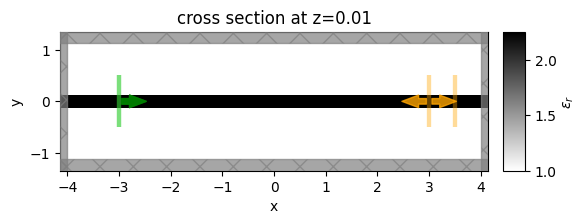

In [9]:
# plot the two simulations
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sim.plot_eps(z=0.01, ax=ax)
plt.show()

### Run simulation

In [10]:
sim_data = web.run(
    sim, task_name="ring_resonator", path="data/simulation_data.hdf5", verbose=True
)

13:03:48 -03 Created task 'ring_resonator' with task_id                         
             'fdve-9f615d1f-b7bf-4845-973f-166d391cb28a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=928060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=646241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\taskId]8;;\]8;id=928060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\=]8;;\]8;id=531626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\fdve]8;;\]8;id=928060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\-9f615d1f-b7b]8;;\
             ]8;id=928060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\f-4845-973f-166d391cb28a']8;;\.

Output()

13:03:51 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:03:57 -03 status = preprocess

13:04:05 -03 Maximum FlexCredit cost: 0.104. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

Output()

13:06:24 -03 status = postprocess

13:06:27 -03 status = success

             View simulation result at                                          
             ]8;id=245108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=603598;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\taskId]8;;\]8;id=245108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\=]8;;\]8;id=75869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\fdve]8;;\]8;id=245108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\-9f615d1f-b7b]8;;\
             ]8;id=245108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9f615d1f-b7bf-4845-973f-166d391cb28a\f-4845-973f-166d391cb28a']8;;\.

Output()

13:06:38 -03 loading simulation from data/simulation_data.hdf5

13:06:39 -03 WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

Next, we can plot the fields at the frequency of the first sideband. As there is no source injecting power in this frequency, the fields are generated due to the nonlinear process.

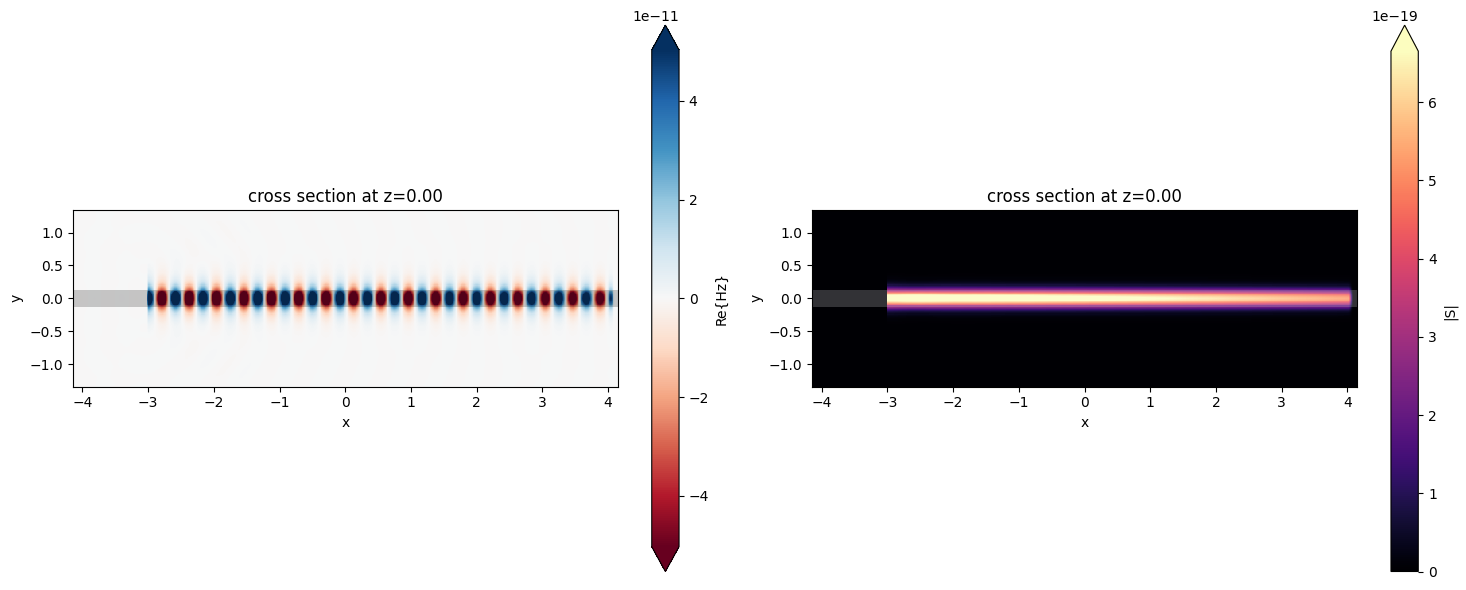

In [11]:
# visualize the fields
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 6))

ax1 = sim_data.plot_field("field", "Hz", val="real", z=0, ax=ax1)
ax2 = sim_data.plot_field("field", "S", val="abs", z=0, ax=ax2)

plt.show()

Now, we can visualize the transmittance spectrum, where the two sidebands are visible at frequencies equally spaced from the pump and signal pulse.

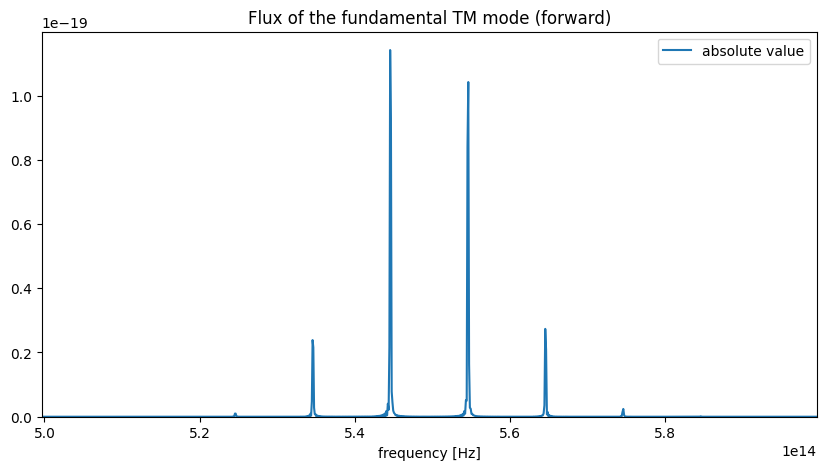

In [12]:
transmission_amps = sim_data["mode"].amps.sel(mode_index=1, direction="+")**2
f, ax = plt.subplots(figsize=(10, 5))
transmission_amps.abs.plot.line(x="f", ax=ax, label="absolute value")
ax.legend()
ax.set_title("Flux of the fundamental TM mode (forward)")
ax.set_ylim(0, None)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()

## Amplitude analysis

We can now vary the amplitude parameter and observe the power at the n = 1 sideband (at 565 Thz). Since the amplitudes of the pump and signal are identical, we expect the power of this band to vary approximately with $\text{amplitude}^5$.

In [30]:
Amps = []
Power1 = []
for amplitude in [50,100,150,200,250,300,350,400,450,500,550,600,700]:

    # creating the sources with the new amplitude value
    s1,s2 = sim.sources
    st1 = s1.source_time.updated_copy(amplitude = amplitude)
    st2 = s2.source_time.updated_copy(amplitude = amplitude)

    sim2 = sim.updated_copy(sources = [s1.updated_copy(source_time = st1),
                                        s2.updated_copy(source_time = st2)])

                                        

    sim_data = web.run(
        sim2, task_name="kerr_sidebands_%i"%amp, path="data/simulation_data.hdf5", verbose=False
    )

    # recording the power for the band n = 1
    band1 = sim.sources[0].source_time.freq0 + (sim.sources[0].source_time.freq0 - sim.sources[1].source_time.freq0)
    bm = (sim_data['fluxMon'].flux.f > band1*0.99) & (sim_data['fluxMon'].flux.f < band1*1.01)
    max = sim_data['fluxMon'].flux[bm].max()

    Amps.append(amplitude)
    Power1.append(max)


14:23:03 -03 WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:25:49 -03 WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:26:01 -03 WARNING: Simulation final field decay value of 0.852 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:28:48 -03 WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:31:34 -03 WARNING: Simulation final field decay value of 0.889 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:34:20 -03 WARNING: Simulation final field decay value of 0.851 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:37:11 -03 WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:37:17 -03 WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:37:31 -03 WARNING: Simulation final field decay value of 0.735 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:37:45 -03 WARNING: Simulation final field decay value of 0.85 is greater than
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:37:57 -03 WARNING: Simulation final field decay value of 0.729 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:38:06 -03 WARNING: Simulation final field decay value of 0.854 is greater    
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

14:38:42 -03 WARNING: The simulation has diverged! For more information, check  
             'SimulationData.log' or use 'web.download_log(task_id)'.           

Exp = 4.81


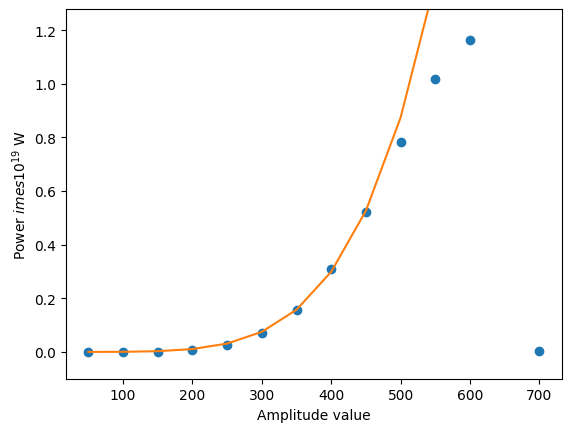

In [46]:
# fitting the data with a polynomial function
from scipy.optimize import curve_fit
func = lambda X,a,n: a*X**n
Y = np.array(Power1)*10**19
res,err = curve_fit(func,Amps[:9],Y[:9],p0 = [1e-9, 5],bounds = ([0,  1],[1,6]))

fig,ax = plt.subplots()
ax.plot(Amps,Y,'o')
ax.plot(Amps,func(np.array(Amps),*(res)))

ax.set_xlabel('Amplitude value')
ax.set_ylabel('Power $\times 10^{19}$ W')

ax.set_ylim(-0.1,1.1*Y.max())

print('Exp = %.2f'%res[1])

plt.show()


It can be observed that the power in the n = 1 band follows an exponential function until amplitude values around 500. Beyond this point, the results deviate from the exponential trend until the simulation diverges for amplitudes greater than 700.

This occurs because the simulations remain stable only for small nonlinearities. The nonlinear permittivity should be smaller than the linear value. Therefore:

$ \epsilon_0 \chi^{(3)} E^3 \ll \epsilon_0 \chi^{(1)} E$

$ \chi^{(3)} E^2 \ll n_0^2-1$

Using the Poynting theorem, and the relation $\chi^{(3)} = (4/3)n_0^2 \epsilon_0 c n_2$, we have:


$\frac{8}{3}\frac{n_0 n_2}{n_0^2 - 1} I \ll 1$

Since the Intensity ($I$) is proportional to $\text{amplitude}^2$, the simulation can quickly become unstable for high amplitude values.


### Further verification

In the previous derivation, we obtained the following conclusions about $z_{-2}$,$z_{1}$:

$$
z_{-2} \approx x^2 \left( y + \frac{y^3}{4} \right)
$$

$$
z_{1} \approx y^2 \left( x + \frac{x^3}{4} \right)
$$

To verify this symmetry, We set the amplitude of the two input signals to half of the original amplitude and observe the change of the sideband signal.

In [15]:
mode_source_p = mode_source_p.copy(update=dict(source_time=td.ContinuousWave(freq0=freqp, fwidth=freq0/10, amplitude=amp)))
mode_source_s = mode_source_s.copy(update=dict(source_time=td.ContinuousWave(freq0=freqs, fwidth=freq0/10, amplitude=amp/2)))

sim_1 = td.Simulation(
    normalize_index=None,
    center=[0, 0, 0],
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    structures=[waveguide],
    sources=[mode_source_p, mode_source_s],
    monitors=[field_monitor, mode_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()
    ),
    medium=background,
)
sim_data_1 = web.run(
    sim_1, task_name="kerr_half_signal", path="data/simulation_data.hdf5", verbose=True
)

mode_source_p = mode_source_p.copy(update=dict(source_time=td.ContinuousWave(freq0=freqp, fwidth=freq0/10, amplitude=amp/2)))
mode_source_s = mode_source_s.copy(update=dict(source_time=td.ContinuousWave(freq0=freqs, fwidth=freq0/10, amplitude=amp)))
sim_2 = td.Simulation(
    normalize_index=None,
    center=[0, 0, 0],
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    structures=[waveguide],
    sources=[mode_source_p, mode_source_s],
    monitors=[field_monitor, mode_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()
    ),
    medium=background,
)
sim_data_2 = web.run(
    sim_2, task_name="kerr_half_pump", path="data/simulation_data.hdf5", verbose=True
)

13:38:30 -03 Created task 'kerr_half_signal' with task_id                       
             'fdve-1d7a7241-e791-42ff-a047-4b63d1308ced' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=579237;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=619009;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\taskId]8;;\]8;id=579237;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\=]8;;\]8;id=542854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\fdve]8;;\]8;id=579237;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\-1d7a7241-e79]8;;\
             ]8;id=579237;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\1-42ff-a047-4b63d1308ced']8;;\.

Output()

13:38:33 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:38:36 -03 status = preprocess

13:38:44 -03 Maximum FlexCredit cost: 0.103. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

Output()

13:41:04 -03 status = postprocess

13:41:07 -03 status = success

             View simulation result at                                          
             ]8;id=953967;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=917930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\taskId]8;;\]8;id=953967;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\=]8;;\]8;id=612724;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\fdve]8;;\]8;id=953967;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\-1d7a7241-e79]8;;\
             ]8;id=953967;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d7a7241-e791-42ff-a047-4b63d1308ced\1-42ff-a047-4b63d1308ced']8;;\.

Output()

13:41:10 -03 loading simulation from data/simulation_data.hdf5

             WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

13:41:11 -03 Created task 'kerr_half_pump' with task_id                         
             'fdve-ec826d19-3b8d-445d-83a1-d76218493fca' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=831797;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=641467;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\taskId]8;;\]8;id=831797;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\=]8;;\]8;id=729558;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\fdve]8;;\]8;id=831797;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\-ec826d19-3b8]8;;\
             ]8;id=831797;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\d-445d-83a1-d76218493fca']8;;\.

Output()

13:41:13 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

13:41:27 -03 status = preprocess

13:41:35 -03 Maximum FlexCredit cost: 0.103. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

Output()

13:43:56 -03 status = postprocess

13:43:59 -03 status = success

             View simulation result at                                          
             ]8;id=997762;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=927566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\taskId]8;;\]8;id=997762;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\=]8;;\]8;id=108213;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\fdve]8;;\]8;id=997762;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\-ec826d19-3b8]8;;\
             ]8;id=997762;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec826d19-3b8d-445d-83a1-d76218493fca\d-445d-83a1-d76218493fca']8;;\.

Output()

13:44:02 -03 loading simulation from data/simulation_data.hdf5

             WARNING: Simulation final field decay value of 1.0 is greater than 
             the simulation shutoff threshold of 1e-05. Consider running the    
             simulation again with a larger 'run_time' duration for more        
             accurate results.                                                  

13:44:03 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

Visualize the output spectrum of two further simualtions.

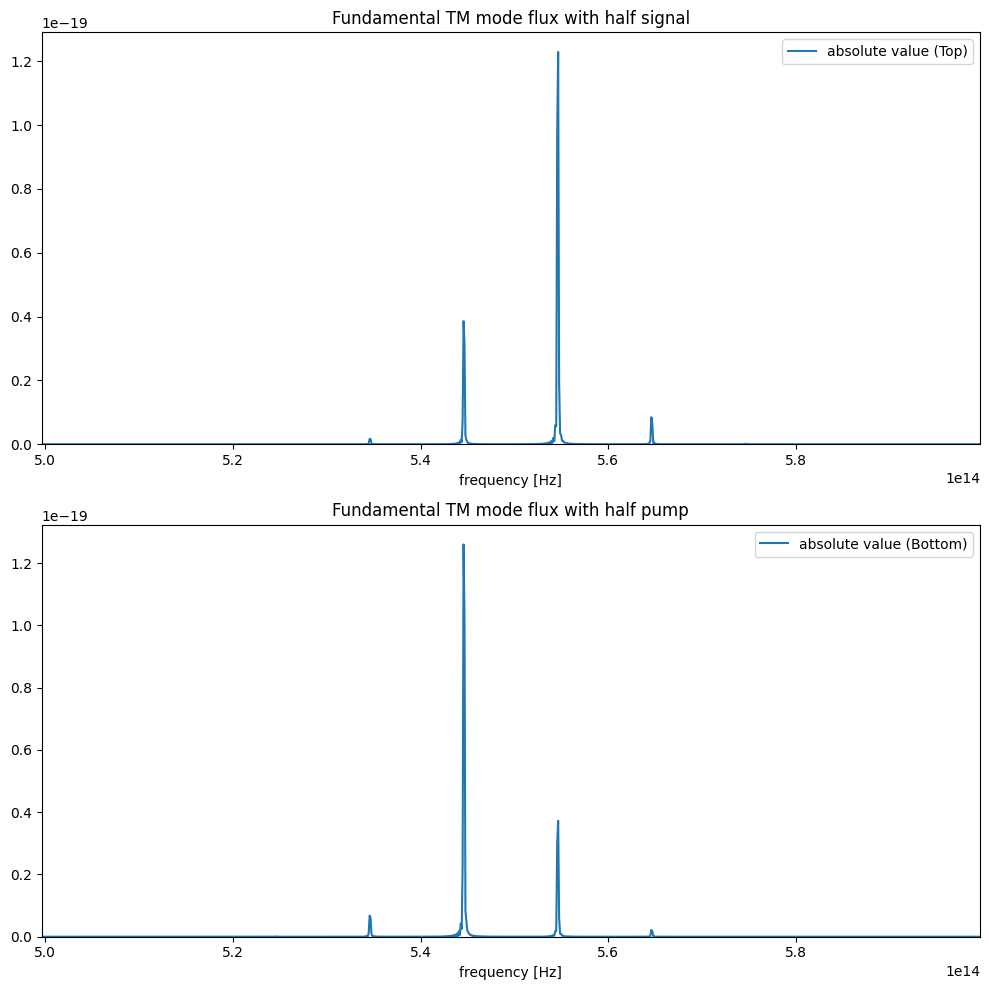

In [16]:
transmission_amps_1 = sim_data_1["mode"].amps.sel(mode_index=1, direction="+")**2
transmission_amps_2 = sim_data_2["mode"].amps.sel(mode_index=1, direction="+")**2
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))


transmission_amps_1.abs.plot.line(x="f", ax=ax1, label="absolute value (Top)")
ax1.legend()
ax1.set_title("Fundamental TM mode flux with half signal")
ax1.set_ylim(0, None)
ax1.set_xlim(freqs_measure[0], freqs_measure[-1])

# Bottom plot1
transmission_amps_2.abs.plot.line(x="f", ax=ax2, label="absolute value (Bottom)")
ax2.legend()
ax2.set_title("Fundamental TM mode flux with half pump")
ax2.set_ylim(0, None)
ax2.set_xlim(freqs_measure[0], freqs_measure[-1])

plt.tight_layout()
plt.show()


From the figure above, we can observe the symmetry for $z_{-2}$, $z_{1}$ and $x$, $y$, which is consistent with the theoretical derivation.